downlaod from kMNIST  

https://github.com/rois-codh/kmnist


In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
from glob import glob
import datetime
import scipy
import scipy.spatial
import pickle
import skimage
import skimage.transform
import random
from skimage.color import rgb2gray
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
classmap = pd.read_csv("./data/kuzushiji/k49_classmap.csv", index_col="index")

In [3]:
classmap.head()

,codepoint,char
index,,
0,U+3042,あ
1,U+3044,い
2,U+3046,う
3,U+3048,え
4,U+304A,お


In [4]:
def get_label_str(index):
    return classmap.iloc[index]["char"]
get_label_str(0)

'あ'

In [5]:
train_images = np.load("./data/kuzushiji/k49-train-imgs.npz")['arr_0']
train_labels = np.load("./data/kuzushiji/k49-train-labels.npz")['arr_0']

In [6]:
len(train_images)

232365

In [7]:
train_images[0].shape

(28, 28)

In [8]:
imgs = train_images[:10]
labels = train_labels[:10]

In [9]:
labels

array([30, 19, 20, 30,  7,  4, 35, 20, 24, 43], dtype=uint8)

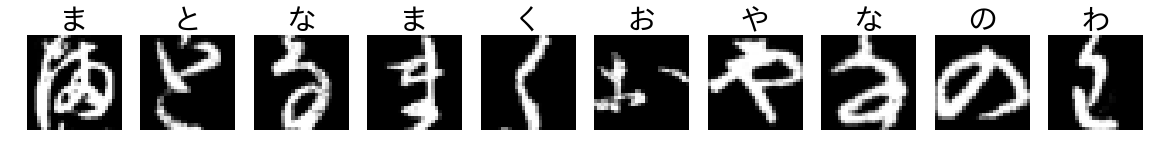

In [10]:
dim = 28

fig, axs = plt.subplots(1, len(imgs), figsize=(20, 3))

for i, (img, label) in enumerate(zip(imgs, labels)):  
        axs[i].imshow(np.reshape(img, (dim, dim)), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(get_label_str(label), fontsize=30)
plt.show()

In [27]:
class DataManager:
    def __init__(self):
        self.test_offset = 0
        self.train_offset = 0
        self.n_classes = 49
        
        self.train_images = np.load("./data/kuzushiji/k49-train-imgs.npz")['arr_0']
        self.train_labels = np.load("./data/kuzushiji/k49-train-labels.npz")['arr_0']
        self.test_images = np.load("./data/kuzushiji/k49-test-imgs.npz")['arr_0']
        self.test_labels = np.load("./data/kuzushiji/k49-test-labels.npz")['arr_0']
        
        self.classmap = pd.read_csv("./data/kuzushiji/k49_classmap.csv", index_col="index")
       
        self.n_test = len(self.test_images)
        self.n_train = len(self.train_images)

        print("test/train: {}/{} = {:.4}".format(
            self.n_test, self.n_train, self.n_test/self.n_train))
        
    def get_label_str(self, index):
        return self.classmap.iloc[index]["char"]
    

    def next_batch(self, kind, num, one_hot=True):
        if kind == "test":
            end = self.test_offset + num
            if end > self.n_test:
                self.test_offset = 0
                end = num
                #random.shuffle(self.test_images)
            images = self.test_images
            labels = self.test_labels
            offset = self.test_offset
        elif kind == "train":
            end = self.train_offset + num
            if end > self.n_train:
                self.train_offset = 0
                end = num
                #random.shuffle(self.train_images)
            images = self.train_images
            labels = self.train_labels
            offset = self.train_offset

        else:
            raise Exception("kind is 'test' or 'train'")

        image_batch = images[offset: end]
        label_batch = [np.identity(49)[l]for l in labels[offset: end]]


        if kind == "test":
            self.test_offset = end
        elif kind == "train":
            self.train_offset = end
        return label_batch, image_batch

In [28]:
dm = DataManager()

test/train: 38547/232365 = 0.1659


In [29]:
labels, imgs = dm.next_batch("test", 10)

In [30]:
imgs.shape

(10, 28, 28)

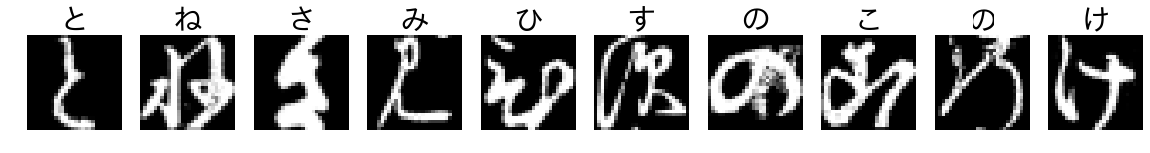

In [31]:
dim = 28

fig, axs = plt.subplots(1, len(imgs), figsize=(20, 3))

for i, (img, label) in enumerate(zip(imgs, labels)):  
        axs[i].imshow(np.reshape(img, (dim, dim)), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(get_label_str(np.argmax(label)), fontsize=30)
plt.show()

In [34]:
def weight_variable(shape):
    w = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(w)


def bias_variable(shape):
    b = tf.constant(0.01, shape=shape)
    return tf.Variable(b)


def conv2d(x, filt, name):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        filt is a filter. filt.shape is [filter_height, filter_width, in_channels, out_channels]
    """ 
    return tf.nn.conv2d(x, filt, strides=[1,1,1,1], padding='SAME', name=name)


def max_pool(x, name, size=2):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        size is a pooling size using ksize.
        (ksize is a kernel size. ksize.shape is [batch_size, height, width, channels]
            The batch_size and channels are usual 1 on pooling. If you want 2x2 pooling, ksize=[1, 2, 2, 1])
    
    """
    return tf.nn.max_pool(x, ksize=[1, size, size, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


def avg_pool(x, name, size=2):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        size is a pooling size using ksize.
        (ksize is a kernel size. ksize.shape is [batch_size, height, width, channels]
            The batch_size and channels are usual 1 on pooling. If you want 2x2 pooling, ksize=[1, 2, 2, 1])
    
    """
    return tf.nn.avg_pool(x, ksize=[1, size, size, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


def conv_layer(x, out_size, name, act="relu"):
    shape =x.get_shape().as_list()
    in_channel = shape[-1]
    with tf.name_scope("conv_{}".format(name)):
        with tf.name_scope('weights'):
            W = weight_variable([5,5, in_channel, out_size])
            variable_summaries(W)        
        with tf.name_scope('biases'):
            b = bias_variable([out_size])
            variable_summaries(b)
        h_conv = conv2d(x, W, "conv2d_{}".format(name))
        h = tf.nn.bias_add(h_conv, b)
        variable_summaries(h)
        
    if act == "relu":
        with tf.name_scope("conv_relu_{}".format(name)):
            h_act = tf.nn.relu(h)
    if act == "ident":
        h_act = h
    return h_act


def fc_layer(x_flatten, out_size, name, act="relu"):
    shape =x_flatten.get_shape().as_list()
    dim = shape[1]
    with tf.name_scope("fc_{}".format(name)):
        with tf.name_scope('weights'):
            W = weight_variable([dim, out_size])
        with tf.name_scope('biases'):   
            b  = bias_variable([out_size])
        h = tf.nn.bias_add(tf.matmul(x_flatten, W), b)
      
    if act == "relu":
        with tf.name_scope("fc_relu_{}".format(name)):
            h_act = tf.nn.relu(h)
    if act == "ident":
        h_act = h
    return h_act


def dropout(x, keep_prob, name):
    with tf.name_scope("dropout_{}".format(name)):
        h = tf.nn.dropout(x, keep_prob)
    return h
    

def flatten(x, name):
    shape = x.get_shape().as_list()
    dim = 1
    for s in shape[1:]:
        dim *= s
    with tf.name_scope(name):
        h = tf.reshape(x, [-1, dim])
    return h


def block(x, out_size, name):
    h_conv_act = conv_layer(x, out_size, name)
    
    with tf.name_scope("pool_{}".format(name)):   
        h_pool1 = max_pool(h_conv_act, name)
        variable_summaries(h_pool1)
    return h_pool1


def variable_summaries(var):  
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [40]:
height = 28
width = 28
image_size = height * width
g1 = None
n_classes = 49

with tf.Graph().as_default() as g1:
    with tf.name_scope('input'):
        keep_prob = tf.placeholder(tf.float32)
        x = tf.placeholder(tf.float32, shape=[None, None, None], name='x-input')
        y_ = tf.placeholder(tf.float32, shape=[None, n_classes], name='y-input')

    with tf.name_scope('input_reshape'):    
        x_image = tf.reshape(x, [-1, height, width, 1])
        tf.summary.image('input',  x_image, n_classes)

    h_pool1 = block(x_image, 32, "1")
    h_pool2 = block(h_pool1, 64, "2")
    h_pool2_flat = flatten(h_pool2, "pool2_flat")
    h_fc1 = fc_layer(h_pool2_flat, 1024, "1", act="relu")
    h_fc1_drop = dropout(h_fc1, keep_prob, "fc1")
    y_conv = fc_layer(h_fc1_drop , n_classes, "2", act="ident")

    with tf.name_scope("loss"):
        print(y_.name)
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
        tf.summary.scalar('cross_entropy', loss)

    with tf.name_scope("optimizer"):
        opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

    with tf.name_scope("accuracy"):
        correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

input/y-input:0


In [41]:
import tensorboard as tb 
tb.show_graph(g1)

In [43]:
n_iter = 50000
batch_size = 100
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
log_dir= "logs/" + time_path  

checkpoint_dir = os.path.abspath(os.path.join(log_dir, "checkpoints"))
checkpoint_prefix = os.path.join(checkpoint_dir, "model")

tf.gfile.MakeDirs(log_dir)
tf.gfile.MakeDirs(checkpoint_dir)

In [44]:
dm = DataManager()

test/train: 38547/232365 = 0.1659


In [ ]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=5)
    
    for i in tqdm(range(n_iter)):
        batch_lbl, batch_img = dm.next_batch("train", batch_size)
        _ = sess.run(opt, feed_dict={x: batch_img, y_: batch_lbl, keep_prob: 0.8})
        
        if i % 100 == 0:
            train_loss, train_accuracy, summary = sess.run([loss, accuracy, merged], feed_dict={x: batch_img, y_:  batch_lbl, keep_prob: 1.0})
            print('step %d, training loss %g, training accuracy %g' % (i, train_loss, train_accuracy))
            train_writer.add_summary(summary, i)
        if i % 500 == 0:
            test_batch_lbl, test_batch_img = dm.next_batch("test", 20000)
            test_accuracy, test_summary, = sess.run([accuracy, merged],  feed_dict={x: test_batch_img, y_: test_batch_lbl, keep_prob: 1.0})
            test_writer.add_summary(test_summary, i)
            path = saver.save(sess, checkpoint_prefix, global_step=i)
            print("Saved model checkpoint to {}\n".format(path))
            print('test accuracy %g' % test_accuracy)

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

step 0, training loss 3.88994, training accuracy 0.04
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_28_15_49_42/checkpoints/model-0

test accuracy 0.02425
step 100, training loss 3.86736, training accuracy 0.02
step 200, training loss 3.80693, training accuracy 0.06
step 300, training loss 3.79946, training accuracy 0.06
step 400, training loss 3.7013, training accuracy 0.14
step 500, training loss 3.63143, training accuracy 0.21
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_28_15_49_42/checkpoints/model-500

test accuracy 0.20345
step 600, training loss 3.45871, training accuracy 0.36
step 700, training loss 3.24754, training accuracy 0.43
step 800, training loss 3.20985, training accuracy 0.4
step 900, training loss 3.09296, training accuracy 0.38
step 1000, training loss 2.88111, training accuracy 0.48
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_28_15_49_42/checkpoints/model-1000

test accuracy 0.3

step 9900, training loss 1.28963, training accuracy 0.67
step 10000, training loss 1.03479, training accuracy 0.77
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_28_15_49_42/checkpoints/model-10000

test accuracy 0.62575
step 10100, training loss 0.950744, training accuracy 0.77
step 10200, training loss 0.908606, training accuracy 0.78
step 10300, training loss 0.88685, training accuracy 0.76
step 10400, training loss 0.979625, training accuracy 0.74
step 10500, training loss 0.911403, training accuracy 0.75
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_28_15_49_42/checkpoints/model-10500

test accuracy 0.63255
step 10600, training loss 1.24386, training accuracy 0.71
step 10700, training loss 0.88873, training accuracy 0.77
step 10800, training loss 0.887255, training accuracy 0.75
step 10900, training loss 1.0971, training accuracy 0.72
step 11000, training loss 1.01628, training accuracy 0.74
Saved model checkpoint to /Users/td

Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_28_15_49_42/checkpoints/model-19500

test accuracy 0.71565
step 19600, training loss 0.773888, training accuracy 0.78
step 19700, training loss 0.625064, training accuracy 0.84
step 19800, training loss 0.655778, training accuracy 0.83
step 19900, training loss 0.636522, training accuracy 0.83
step 20000, training loss 0.636169, training accuracy 0.84
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_28_15_49_42/checkpoints/model-20000

test accuracy 0.7183
step 20100, training loss 0.770187, training accuracy 0.77
step 20200, training loss 0.685631, training accuracy 0.84
step 20300, training loss 0.733446, training accuracy 0.81
step 20400, training loss 0.581715, training accuracy 0.85
step 20500, training loss 0.893528, training accuracy 0.78
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_28_15_49_42/checkpoints/model-20500

test accuracy 0.7216
step 20600, t

step 29100, training loss 0.539764, training accuracy 0.86
step 29200, training loss 0.404516, training accuracy 0.9
step 29300, training loss 0.532631, training accuracy 0.85
step 29400, training loss 0.627141, training accuracy 0.81
step 29500, training loss 0.524203, training accuracy 0.82
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_28_15_49_42/checkpoints/model-29500

test accuracy 0.76605
step 29600, training loss 0.407378, training accuracy 0.92
step 29700, training loss 0.423215, training accuracy 0.89
step 29800, training loss 0.447526, training accuracy 0.9
step 29900, training loss 0.578983, training accuracy 0.83
step 30000, training loss 0.737284, training accuracy 0.79
Saved model checkpoint to /Users/tdual/Workspace/cnn_feature/logs/2018_12_28_15_49_42/checkpoints/model-30000

test accuracy 0.7677
step 30100, training loss 0.48349, training accuracy 0.87
step 30200, training loss 0.492008, training accuracy 0.85
step 30300, training loss 0.34

In [ ]:
ckpt_dir = os.path.join(log_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path
latest_ckpt

In [ ]:
#latest_ckpt = '/Users/tdual/Workspace/cnn_feature/logs/2018_09_19_00_41_54/checkpoints/model-100'

# similarity

In [ ]:
with tf.Session(graph=g1) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, latest_ckpt)
    h_fc1_ = sess.run(h_fc1, feed_dict={x: mnist.test.images})
    y_conv_ = sess.run(y_conv, feed_dict={x: mnist.test.images, keep_prob: 1.0})

In [ ]:
h_fc1_[0].shape

In [ ]:
y_conv_[0].shape

In [ ]:
from scipy.spatial import distance
pairwise_10 = distance.squareform(distance.pdist(y_conv_, metric="cosine"))
pairwise_1024 = distance.squareform(distance.pdist(h_fc1_, metric="cosine"))

In [ ]:
def similar_to(img_id, num=5, distance=False, pairwise=pairwise_1024):
    img = pairwise[img_id]
    ids = np.argsort(img)[0: num] 
    if distance:
        dist = np.sort(img)[0: num]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

def show_sim_image(img_id, num=5, pairwise=pairwise_1024):
    id_list = similar_to(img_id, num=num, distance=True, pairwise=pairwise)
    fig, axs = plt.subplots(1, len(id_list), figsize=(20, 3))
    for i, id in enumerate(id_list):
        print(id)
        img =imgs[id[0]]
        axs[i].imshow(255 - np.reshape(img,[28,28]),cmap='gray')
        axs[i].axis('off')
    plt.show()

In [ ]:
imgs = mnist.test.images

In [ ]:
show_sim_image(1000, 10, pairwise=pairwise_1024)

In [ ]:
show_sim_image(1000, 10, pairwise=pairwise_10)

In [ ]:
show_sim_image(0, 10)

# Visualization
ref: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/


In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = os.path.join(os.getcwd(), log_dir, 'visualization')


if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
tf.gfile.MakeDirs(LOG_DIR)

In [ ]:
str_labels = ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']
with open(os.path.join(LOG_DIR, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(mnist.test.labels):
        f.write("%d\t%s\n" % (index, str_labels[np.argmax(label)]))

In [ ]:
rows =[]
columns = []
sprite_size = int(np.sqrt(len(mnist.test.images)))

print("sprite image size {size} * {size}".format(**{"size": sprite_size}))

for img in mnist.test.images:
    img_ = np.reshape(img, [height, width]) # reshape and invert grayscale 
    rows.append(img_)

for i in range(sprite_size):
    columns.append(np.concatenate(rows[sprite_size * i : sprite_size * (i + 1)], axis=1))
    
image = np.concatenate(columns, axis=0)#.astype(np.uint8)
imageio.imwrite(os.path.join(LOG_DIR, 'sprite.png'), image)

In [ ]:
embedding_var = tf.Variable(mnist.test.images, name='mnist_pixels')
config = projector.ProjectorConfig()

embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
embedding.sprite.image_path = os.path.join(LOG_DIR,  'sprite.png')
embedding.sprite.single_image_dim.extend([28, 28])

summary_writer = tf.summary.FileWriter(LOG_DIR)
projector.visualize_embeddings(summary_writer, config)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR,  'model.ckpt'), 0)

```
tensorboard --logdir=logs/visualization/
```

In [ ]:
test_images = []
orig_images = []
for path in tqdm(imgs):
    img_ = get_resize_img(path , dim) 
    if img_.shape != (28,28,3,):
        print(path)
        print(img_.shape)
        rm_list.append(path)
    else:
        test_images.append(get_flatten_img(path, invert_gray=True))
        orig_images.append(imread(path))
test_images = np.array(test_images)

In [ ]:
test_images = np.reshape(test_images, [-1, 28*28])

In [ ]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    h_fc1_ = sess.run(h_fc1, feed_dict={x: test_images})

In [ ]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(h_fc1_, metric="cosine"))

In [ ]:
def similar_to(img_id, num=5, distance=False):
    img = pairwise[img_id]
    ids = np.argsort(img)[0: num] 
    if distance:
        dist = np.sort(img)[0: num]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

def show_sim_image(img_id, num=5):
    id_list = similar_to(img_id, num=num,distance=True)
    fig, axs = plt.subplots(1, len(id_list), figsize=(20, 3))
    for i, id in enumerate(id_list):
        print(id)
        img =orig_images[id[0]]
        axs[i].imshow(img ,cmap='gray')
        axs[i].axis('off')
    plt.show()

In [ ]:
show_sim_image(0,10)

In [ ]:
show_sim_image(2,10)

In [ ]:
len(h_fc1_)

In [ ]:
#with open("mnist_feature.pkl", "wb") as f:
#    pickle.dump(h_fc1_, f)

# faiss

In [ ]:
dim = h_fc1_[0].shape[0]
dim

In [ ]:
h_fc1_.shape

In [ ]:
import faiss
item_index = faiss.IndexFlatL2(dim)
item_index.add(h_fc1_)

In [ ]:
item_index.ntotal

In [ ]:
def show_sim_by_faiss(target_index):
    plt.imshow(orig_images[target_index])
    plt.title("the key image")
    plt.axis('off')
    plt.show()
    key_vec = np.array([h_fc1_[target_index]])
    
    scores, indices = item_index.search(key_vec, 10)
    
    fig, axs = plt.subplots(1, len(indices[0]), figsize=(20, 3))
    for i, (id, s) in enumerate(zip(indices[0], scores[0]) ):
        img =orig_images[id]
        axs[i].imshow(img ,cmap='gray')
        axs[i].set_title(s)
        axs[i].axis('off')
    plt.show()

In [ ]:
show_sim_by_faiss(3)